# Logarithmic spiral modelling using Bayesian statistics

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from scipy.optimize import minimize
import theano
import theano.tensor as tt
from gzbuilderspirals import pa_from_r_theta
from sklearn.metrics import mean_squared_error
from gzbuilderspirals.oo import Pipeline, Arm

In [2]:
# plt.style.use('seaborn')

In [3]:
a = Arm.load('lib/spiral_arms/20902040-0.pickle')
arm = Arm(a.get_parent(), a.arms)

In [4]:
t = arm.t
R = arm.R
ls = arm.polar_logsp
gzb_pa = arm.chirality * arm.pa

Least squares pitch angle: -10.068˚


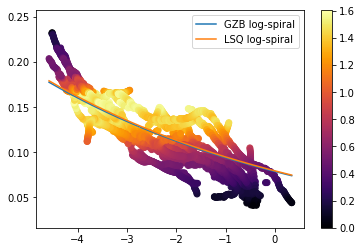

In [17]:
def logsp(t, a, phi):
    b = np.tan(np.deg2rad(phi))
    return a * np.exp(b*t)

point_weights = arm.point_weights
def f(p):
    model = logsp(t, *p)
    return mean_squared_error(
        R,
        model,
        sample_weight=point_weights
    )

res = minimize(
    f,
    (0.1, arm.pa * arm.chirality)
)
sc = plt.scatter(
    t, R,
    vmin=point_weights.min(),
    vmax=point_weights.max(),
    c=point_weights,
    cmap=plt.cm.get_cmap('inferno'),
)
plt.colorbar(sc)
plt.plot(ls[0], ls[1], label='GZB log-spiral')
plt.plot(ls[0], logsp(ls[0], *res['x']), label='LSQ log-spiral')
plt.legend();
print('Least squares pitch angle: {:.3f}˚'.format(res['x'][1]))

In [7]:
SHOULD_MODEL_EXPLICITLY = True

In [8]:
pw_mask = arm.point_weights != 0
with pm.Model() as model:
    # two possible options regarding modelling phi:
    if SHOULD_MODEL_EXPLICITLY:
        # model phi as a normal distribution with priors on the normal parameters
        phi_mu = pm.Uniform('phi_mu', lower=-90, upper=90, testval=arm.chirality * arm.pa)
        phi_sd = pm.HalfCauchy('phi_sd', beta=10, testval=0.01)
        phi = pm.Normal('phi', mu=phi_mu, sd=phi_sd)
    else:
        # phi has a uniform prior over all possible values (weakly informative)
        phi = pm.Uniform('phi', lower=-90, upper=90, testval=arm.chirality * arm.pa)

    # model a as a uniform, which we scale later so our varibles have similar magnitude
    a = pm.Uniform('a', lower=0, upper=1000, testval=10)

    # define our equation for mu_r
    mu_r = a / 100 * tt.exp(tt.tan(phi * np.pi / 180) * t[pw_mask])

    # define our expected error on r (different to error on phi)
    base_sigma = pm.HalfCauchy('sigma', beta=10, testval=0.01)
    sigma_y = theano.shared(
        np.asarray(np.sqrt(arm.point_weights[pw_mask]), dtype=theano.config.floatX),
        name='sigma_y'
    )
    sigmas = base_sigma / sigma_y

    # define our likelihood function
    likelihood = pm.Normal('R', mu=mu_r, sd=sigmas, observed=R[pw_mask])
    # run the sampler
    trace = pm.sample(2000, tune=1500, cores=2, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, phi, phi_sd, phi_mu]
Sampling 2 chains: 100%|██████████| 7000/7000 [01:05<00:00, 107.00draws/s]
There were 489 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5965679308189076, but should be close to 0.8. Try to increase the number of tuning steps.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


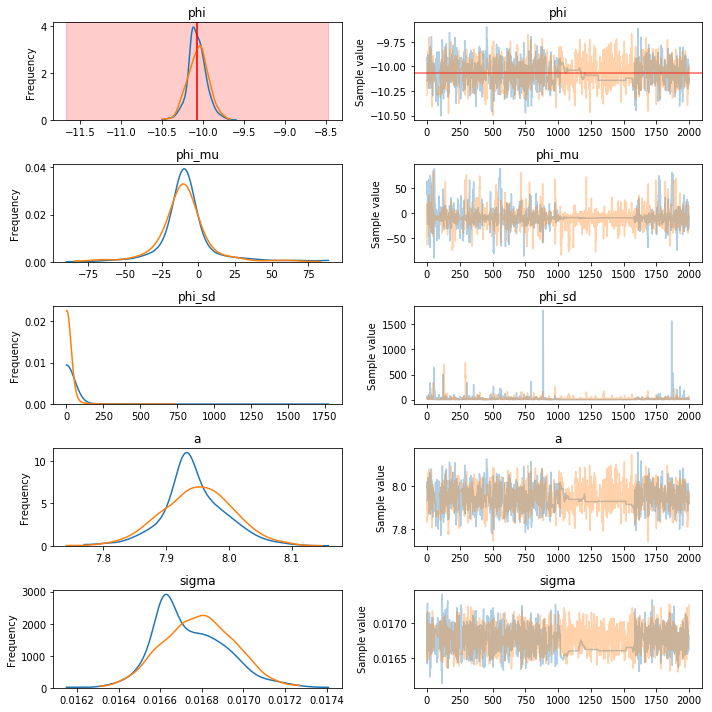

In [9]:
n_vars = sum(1 for i in trace.varnames if not i[-2:] == '__')
f, ax = plt.subplots(ncols=2, nrows=n_vars, figsize=(10, 2*n_vars))
pm.traceplot(trace, lines={'phi': arm.chirality * arm.pa}, ax=ax)
plt.sca(ax[0][0])
l = ax[0][0].get_ylim()[1]
plt.fill_betweenx([0, l], *np.array((-1, 1)) * arm.sigma_pa + arm.chirality * arm.pa, color='r', alpha=0.2)

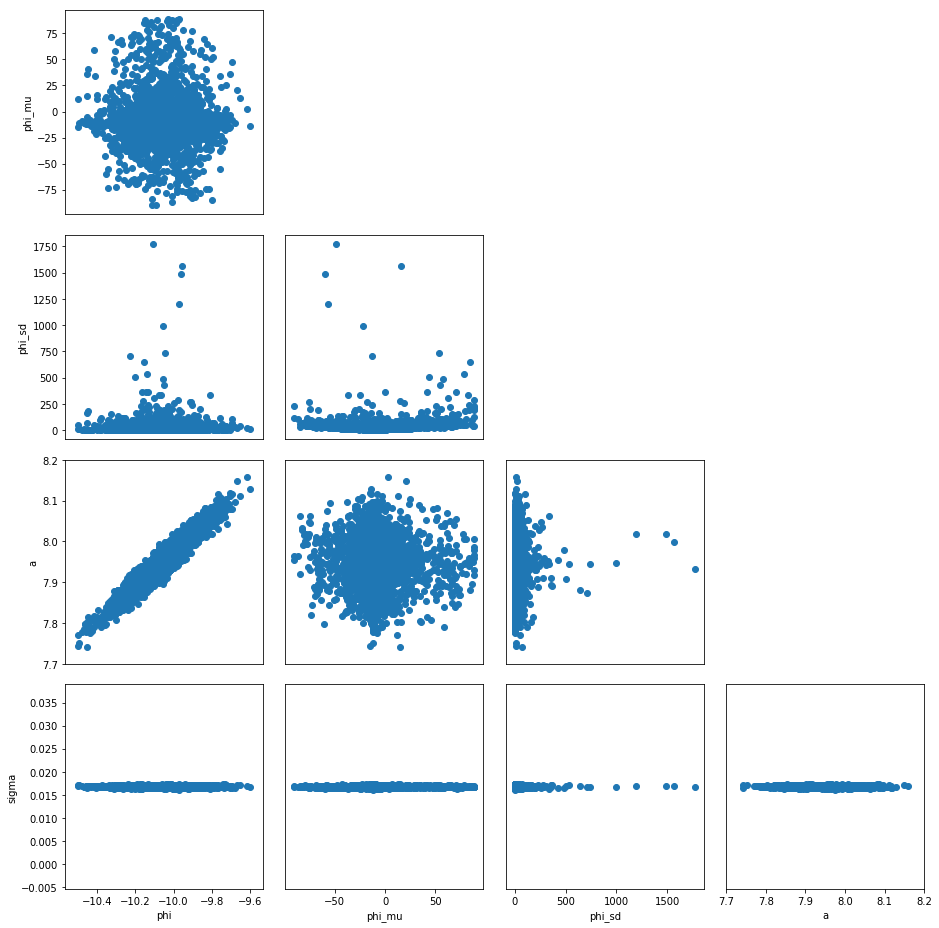

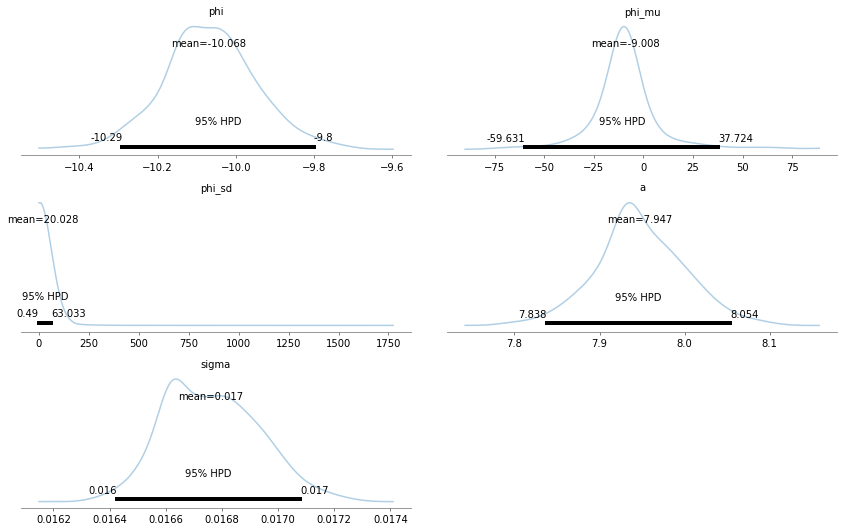

In [10]:
pm.plots.pairplot(trace)
pm.plots.plot_posterior(trace, kde_plot=True);

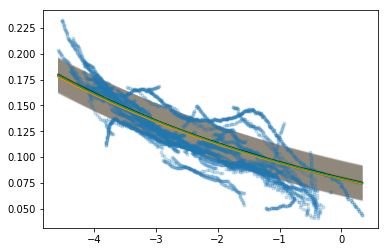

In [11]:
phi_samples = np.expand_dims(trace['phi'][500:], 1)
a_samples = np.expand_dims(trace['a'][500:], 1)
err_samples = np.expand_dims(trace['sigma'][500:], 1)
t_ = np.linspace(t.min(), t.max(), 50)
p_t = a_samples / 100 * np.exp(np.tan(np.deg2rad(phi_samples)) * t_)

plt.plot(t, R, '.', alpha=0.2)
choice = np.random.choice(np.arange(len(p_t)), size=100, replace=False)
for s, err in zip(p_t[choice], err_samples[choice]):
    plt.plot(t_, s, 'k', alpha=0.02)
    plt.fill_between(t_, s - err, s + err, alpha=0.01)
plt.plot(ls[0], ls[1], label='GZB log spiral')
plt.plot(ls[0], logsp(ls[0], trace['a'].mean() / 100, trace['phi'].mean()),
         label='PMY3 log spiral')

In [12]:
print('Pas')
print('\tGZB:  {:.2f}˚ ± {:.3f}'.format(
    arm.pa * arm.chirality, arm.sigma_pa
))
print('\tPYMC: {:.2f}˚ ± {:.3f}'.format(
    trace['phi'].mean(),
    trace['phi'].std(),
))

Pas
	GZB:  -10.07˚ ± 1.603
	PYMC: -10.07˚ ± 0.121
